In [1]:
# check python version
import sys
print(sys.version)

3.10.9 (main, Dec 15 2022, 10:44:50) [Clang 14.0.0 (clang-1400.0.29.202)]


## Data Pipeline

In this project I will showcase how to ETL female literacy rate data from the World Bank by utilizing its API. 

More precisely, this table: *Literacy rate, adult female (% of females ages 15 and above)*

My ultimate goal is to use this data to create a data analysis dashboard that shows the gender disparity in the STEM field, particularly in Latin America. This dataset will be part of a collection of datasets I will use to make my analysis

If you want to know more about this API check the documentation here: https://datahelpdesk.worldbank.org/knowledgebase/articles/898581-api-basic-call-structures

### Step 1: Data Extraction
We will start by extracting data from the UNESCO data portal. For this, we need to use web scraping tools to automate the data extraction process.

In [2]:
# Install dependencies
!pip install -r requirements.txt

In [3]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

##### API endpoint and parameters
I am defining the parameters of my extracted data here in a param dictionary. The `requests` library automatically encodes these parameters into the url. The parameters are available in the [API's documentation](https://datahelpdesk.worldbank.org/knowledgebase/articles/898581-api-basic-call-structures). This improves code readability.

* **JSON**: I want for the raw data to be extracted in json format as it's easier to read, more compact, and therefore faster to parse through 
* **date**: This is the date range of my data

In [4]:
# World Bank API endpoint URL

url = "https://api.worldbank.org/v2/country/all/indicator/SE.ADT.LITR.FE.ZS"

# Establish the parameters you want your data to have
params = {
    "format": "json",
    "date": "2000:2023",
    "per_page": 1000
}

**Important Note**:
We want to ensure we are extracting all the data. Since this is API returns paginated responses we have to ensure we are fetching all the pages

There are multiple things happening within this function. 

We know that the first record of the json response for each page `data[0]` is metadata , *I discovered this when I extracted a single page*. Therefore: 
1. We are discarding the metadata by populating the list `all_data` with the actual data which is inside the second record in the json response `data[1]`
2. Once we don't find any more data records we break out of the while loop and return all the data in a single list!

In [5]:
# Return all the pages from the paginated API responses

def fetch_all(url, params):
    all_data = []
    page = 1
    
    while True:
        params['page'] = page
        response = requests.get(url, params=params)
        data = response.json()
        
        # Check if there are records
        if len(data) > 1 and data[1]:
            print(data[0])  # this will print the metadata to ensure that we fetch all the pages
            all_data.extend(data[1])
            page += 1
        else:
            break
    return all_data

In [6]:
data = fetch_all(url, params)

{'page': 1, 'pages': 7, 'per_page': 1000, 'total': 6384, 'sourceid': '2', 'lastupdated': '2024-05-30'}
{'page': 2, 'pages': 7, 'per_page': 1000, 'total': 6384, 'sourceid': '2', 'lastupdated': '2024-05-30'}
{'page': 3, 'pages': 7, 'per_page': 1000, 'total': 6384, 'sourceid': '2', 'lastupdated': '2024-05-30'}
{'page': 4, 'pages': 7, 'per_page': 1000, 'total': 6384, 'sourceid': '2', 'lastupdated': '2024-05-30'}
{'page': 5, 'pages': 7, 'per_page': 1000, 'total': 6384, 'sourceid': '2', 'lastupdated': '2024-05-30'}
{'page': 6, 'pages': 7, 'per_page': 1000, 'total': 6384, 'sourceid': '2', 'lastupdated': '2024-05-30'}
{'page': 7, 'pages': 7, 'per_page': 1000, 'total': 6384, 'sourceid': '2', 'lastupdated': '2024-05-30'}


### Step 2. Data Transformation

##### Convert to a raw data to DataFrame


In [7]:
df = pd.DataFrame(data)

##### Exploratory Analysis

We want to explore how the data looks, clean it up and get it ready for analysis

In [8]:
df.shape

(6384, 8)

In [9]:
df.columns

Index(['indicator', 'country', 'countryiso3code', 'date', 'value', 'unit',
       'obs_status', 'decimal'],
      dtype='object')

In [10]:
df.head()

,indicator,country,countryiso3code,date,value,unit,obs_status,decimal
0,"{'id': 'SE.ADT.LITR.FE.ZS', 'value': 'Literacy...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2023,NaN,,,0
1,"{'id': 'SE.ADT.LITR.FE.ZS', 'value': 'Literacy...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2022,67.545410,,,0
2,"{'id': 'SE.ADT.LITR.FE.ZS', 'value': 'Literacy...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2021,67.454010,,,0
3,"{'id': 'SE.ADT.LITR.FE.ZS', 'value': 'Literacy...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2020,67.536987,,,0
4,"{'id': 'SE.ADT.LITR.FE.ZS', 'value': 'Literacy...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2019,67.289780,,,0


First I am exploring the fields of the *indicator* column

In [11]:
df['indicator'][0]

{'id': 'SE.ADT.LITR.FE.ZS',
 'value': 'Literacy rate, adult female (% of females ages 15 and above)'}

In [12]:
df['indicator'][0]['id']

'SE.ADT.LITR.FE.ZS'

In [13]:
df['indicator'][6300]

{'id': 'SE.ADT.LITR.FE.ZS',
 'value': 'Literacy rate, adult female (% of females ages 15 and above)'}

**Process notes**: They might all be the same? I will extract the ids and values into a separate column each

In [14]:
# Place the indicator id in a separate column for detailed examination

df['indicator_id'] = df['indicator'].apply(lambda x: x['id'])

In [15]:
df['indicator_id'].unique() # It seems like this is not of much help - it's just the data code

array(['SE.ADT.LITR.FE.ZS'], dtype=object)

In [16]:
# Place the indicator value in a separate column for detailed examination

df['indicator_val'] = df['indicator'].apply(lambda x: x['value'])

In [17]:
df['indicator_val'].unique() # same for this - not so relevant

array(['Literacy rate, adult female (% of females ages 15 and above)'],
      dtype=object)

**Process notes**: I decided to drop the indicator column and its derived columns as they're not relevant for the purposes of extracting this data

In [18]:
df.drop(columns=['indicator', 'indicator_id', 'indicator_val'], inplace=True)

In [19]:
df.columns

Index(['country', 'countryiso3code', 'date', 'value', 'unit', 'obs_status',
       'decimal'],
      dtype='object')

**Process notes**: Now, I'll explore the country column

In [20]:
df['country'][0]

{'id': 'ZH', 'value': 'Africa Eastern and Southern'}

In [21]:
df['country_id'] = df['country'].apply(lambda x: x['id'])

In [22]:
df['country_val'] = df['country'].apply(lambda x: x['value'])

In [23]:
df['country_id'].unique()

array(['ZH', 'ZI', '1A', 'S3', 'B8', 'V2', 'Z4', '4E', 'T4', 'XC', 'Z7',
       '7E', 'T7', 'EU', 'F1', 'XE', 'XD', 'XF', 'ZT', 'XH', 'XI', 'XG',
       'V3', 'ZJ', 'XJ', 'T2', 'XL', 'XO', 'XM', 'XN', 'ZQ', 'XQ', 'T3',
       'XP', 'XU', 'XY', 'OE', 'S4', 'S2', 'V4', 'V1', 'S1', '8S', 'T5',
       'ZG', 'ZF', 'T6', 'XT', '1W', 'AF', 'AL', 'DZ', 'AS', 'AD', 'AO',
       'AG', 'AR', 'AM', 'AW', 'AU', 'AT', 'AZ', 'BS', 'BH', 'BD', 'BB',
       'BY', 'BE', 'BZ', 'BJ', 'BM', 'BT', 'BO', 'BA', 'BW', 'BR', 'VG',
       'BN', 'BG', 'BF', 'BI', 'CV', 'KH', 'CM', 'CA', 'KY', 'CF', 'TD',
       'JG', 'CL', 'CN', 'CO', 'KM', 'CD', 'CG', 'CR', 'CI', 'HR', 'CU',
       'CW', 'CY', 'CZ', 'DK', 'DJ', 'DM', 'DO', 'EC', 'EG', 'SV', 'GQ',
       'ER', 'EE', 'SZ', 'ET', 'FO', 'FJ', 'FI', 'FR', 'PF', 'GA', 'GM',
       'GE', 'DE', 'GH', 'GI', 'GR', 'GL', 'GD', 'GU', 'GT', 'GN', 'GW',
       'GY', 'HT', 'HN', 'HK', 'HU', 'IS', 'IN', 'ID', 'IR', 'IQ', 'IE',
       'IM', 'IL', 'IT', 'JM', 'JP', 'JO', 'KZ', 'K

In [24]:
df['country_val'].unique()

array(['Africa Eastern and Southern', 'Africa Western and Central',
       'Arab World', 'Caribbean small states',
       'Central Europe and the Baltics', 'Early-demographic dividend',
       'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)',
       'East Asia & Pacific (IDA & IBRD countries)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)',
       'Europe & Central Asia (IDA & IBRD countries)', 'European Union',
       'Fragile and conflict affected situations',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only',
       'IDA total', 'Late-demographic dividend',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Latin America & the Caribbean (IDA & IBRD countries)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle in

**Process notes**: This data is very relevant! I will clean it up more as I am focusing my analysis on the LATAM region. I am going to create a mask so I only get the information for the countries I care about. Since this also mentions regions, I will also extract the relevant ones.

In [25]:
latam_countries = [
    'Mexico', 'Colombia', 'Venezuela', 'Panama', 'Honduras', 
    'Nicaragua','El Salvador','Costa Rica', 'Belize', 'Guatemala', 
    'Argentina', 'Bolivia','Brazil', 'Chile', 'Cuba', 
    'Dominican Republic', 'Ecuador', 'Paraguay', 'Peru', 'Uruguay']

In [26]:
latam_regions = [
    'Latin America & Caribbean',
    'Latin America & Caribbean (excluding high income)',
    'Latin America & the Caribbean (IDA & IBRD countries)']

In [27]:
latam_all = [
    'Mexico', 'Colombia', 'Venezuela', 'Panama', 'Honduras', 
    'Nicaragua','El Salvador','Costa Rica', 'Belize', 'Guatemala', 
    'Argentina', 'Bolivia','Brazil', 'Chile', 'Cuba', 
    'Dominican Republic', 'Ecuador', 'Paraguay', 'Peru', 'Uruguay',
    'Latin America & Caribbean',
    'Latin America & Caribbean (excluding high income)',
    'Latin America & the Caribbean (IDA & IBRD countries)']

In [28]:
countries_mask = df['country_val'].isin(latam_countries)

In [29]:
regions_mask = df['country_val'].isin(latam_regions)

In [30]:
all_mask = df['country_val'].isin(latam_all)

In [31]:
# df cleaned by latam countries

countries_df = df[countries_mask]
countries_df

,country,countryiso3code,date,value,unit,obs_status,decimal,country_id,country_val
1344,"{'id': 'AR', 'value': 'Argentina'}",ARG,2023,NaN,,,0,AR,Argentina
1345,"{'id': 'AR', 'value': 'Argentina'}",ARG,2022,NaN,,,0,AR,Argentina
1346,"{'id': 'AR', 'value': 'Argentina'}",ARG,2021,NaN,,,0,AR,Argentina
1347,"{'id': 'AR', 'value': 'Argentina'}",ARG,2020,NaN,,,0,AR,Argentina
1348,"{'id': 'AR', 'value': 'Argentina'}",ARG,2019,NaN,,,0,AR,Argentina
...,...,...,...,...,...,...,...,...,...
6163,"{'id': 'UY', 'value': 'Uruguay'}",URY,2004,NaN,,,0,UY,Uruguay
6164,"{'id': 'UY', 'value': 'Uruguay'}",URY,2003,NaN,,,0,UY,Uruguay
6165,"{'id': 'UY', 'value': 'Uruguay'}",URY,2002,NaN,,,0,UY,Uruguay
6166,"{'id': 'UY', 'value': 'Uruguay'}",URY,2001,NaN,,,0,UY,Uruguay


**Process notes**: I am noticing lots of null values in the value column, which are important values, I am going to try to check if there are any non null values there.

In [32]:
countries_df = countries_df[countries_df['value'].notnull()]
countries_df

,country,countryiso3code,date,value,unit,obs_status,decimal,country_id,country_val
1366,"{'id': 'AR', 'value': 'Argentina'}",ARG,2001,97.193413,,,0,AR,Argentina
1654,"{'id': 'BZ', 'value': 'Belize'}",BLZ,2001,81.300003,,,0,BZ,Belize
1731,"{'id': 'BO', 'value': 'Bolivia'}",BOL,2020,90.502586,,,0,BO,Bolivia
1736,"{'id': 'BO', 'value': 'Bolivia'}",BOL,2015,88.582863,,,0,BO,Bolivia
1739,"{'id': 'BO', 'value': 'Bolivia'}",BOL,2012,91.873268,,,0,BO,Bolivia
...,...,...,...,...,...,...,...,...,...
6157,"{'id': 'UY', 'value': 'Uruguay'}",URY,2010,98.490952,,,0,UY,Uruguay
6158,"{'id': 'UY', 'value': 'Uruguay'}",URY,2009,98.533722,,,0,UY,Uruguay
6159,"{'id': 'UY', 'value': 'Uruguay'}",URY,2008,98.463661,,,0,UY,Uruguay
6160,"{'id': 'UY', 'value': 'Uruguay'}",URY,2007,98.241928,,,0,UY,Uruguay


In [33]:
# I'll also change the column country_val to country_name for clarity
countries_df = countries_df.rename(columns={"country_val": "country_name"})
countries_df

,country,countryiso3code,date,value,unit,obs_status,decimal,country_id,country_name
1366,"{'id': 'AR', 'value': 'Argentina'}",ARG,2001,97.193413,,,0,AR,Argentina
1654,"{'id': 'BZ', 'value': 'Belize'}",BLZ,2001,81.300003,,,0,BZ,Belize
1731,"{'id': 'BO', 'value': 'Bolivia'}",BOL,2020,90.502586,,,0,BO,Bolivia
1736,"{'id': 'BO', 'value': 'Bolivia'}",BOL,2015,88.582863,,,0,BO,Bolivia
1739,"{'id': 'BO', 'value': 'Bolivia'}",BOL,2012,91.873268,,,0,BO,Bolivia
...,...,...,...,...,...,...,...,...,...
6157,"{'id': 'UY', 'value': 'Uruguay'}",URY,2010,98.490952,,,0,UY,Uruguay
6158,"{'id': 'UY', 'value': 'Uruguay'}",URY,2009,98.533722,,,0,UY,Uruguay
6159,"{'id': 'UY', 'value': 'Uruguay'}",URY,2008,98.463661,,,0,UY,Uruguay
6160,"{'id': 'UY', 'value': 'Uruguay'}",URY,2007,98.241928,,,0,UY,Uruguay


**Process notes**: Ok great! There are some non-null values in the values column. The number of records diminished greatly from 456 to 169 - we have to keep an eye on that. 

I also noticed now that there are multiple records for these countries by year. This might be useful to visualize and analyze how the literacy rates have improved of decreased through the years - but I also would like to see the most recent data. I will get the **most recent records for each country** and store it in another df.

To do this I will aggregate the data by country and then fetch the most recent year (the max)

In [34]:
most_recent_mask = countries_df.groupby('country_name')['date'].idxmax()

most_recent_country_df = countries_df.loc[most_recent_mask]

**Process thoughts:** I am going to drop some columns, here's why:
* the `country` column since I already extracted its data
* `unit`, `obs_status`, and `decimal` as we don't have any data there

In [35]:
most_recent_country_df = most_recent_country_df.drop(columns=['country', 'unit', 'obs_status', 'decimal'])

most_recent_country_df

,countryiso3code,date,value,country_id,country_name
1366,ARG,2001,97.193413,AR,Argentina
1654,BLZ,2001,81.300003,BZ,Belize
1731,BOL,2020,90.502586,BO,Bolivia
1801,BRA,2022,94.919998,BR,Brazil
2137,CHL,2022,97.120003,CL,Chile
2187,COL,2020,95.875061,CO,Colombia
2282,CRI,2021,98.099998,CR,Costa Rica
2354,CUB,2021,99.717148,CU,Cuba
2521,DOM,2022,95.599998,DO,Dominican Republic
2545,ECU,2022,93.050751,EC,Ecuador


**Process thoughts:** I am going to reset the index and move the columns around to finish tidying my df up :)

In [36]:
most_recent_country_df = most_recent_country_df.reset_index(drop=True)
most_recent_country_df = most_recent_country_df[['country_name', 'countryiso3code', 'country_id', 'date', 'value']]
most_recent_country_df

,country_name,countryiso3code,country_id,date,value
0,Argentina,ARG,AR,2001,97.193413
1,Belize,BLZ,BZ,2001,81.300003
2,Bolivia,BOL,BO,2020,90.502586
3,Brazil,BRA,BR,2022,94.919998
4,Chile,CHL,CL,2022,97.120003
5,Colombia,COL,CO,2020,95.875061
6,Costa Rica,CRI,CR,2021,98.099998
7,Cuba,CUB,CU,2021,99.717148
8,Dominican Republic,DOM,DO,2022,95.599998
9,Ecuador,ECU,EC,2022,93.050751


**Process notes:** great! This looks way better than what we started with. I decided to keep the iso codes and ids in case I can merge this data with other data I source at a later date. Lets visualize this!

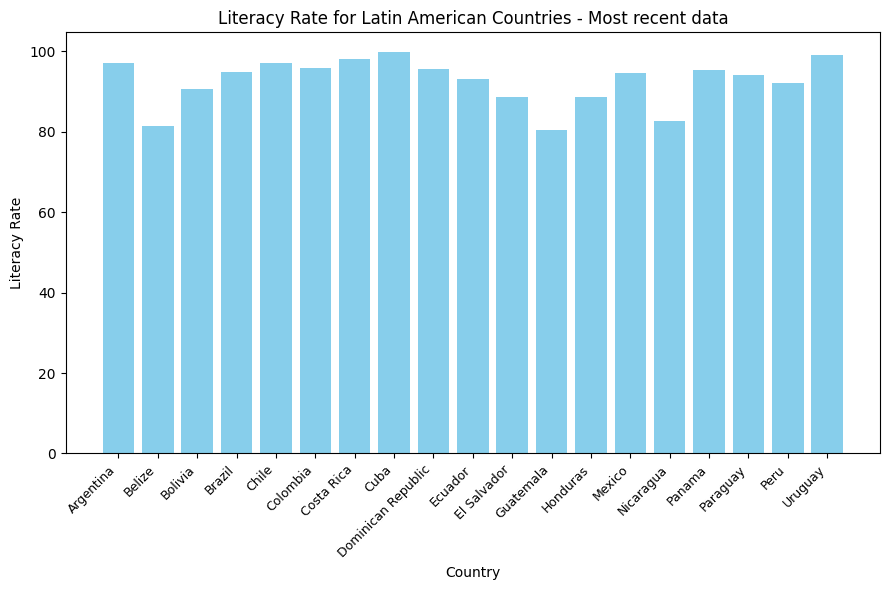

In [59]:
plt.figure(figsize=(9, 6))
plt.bar(most_recent_country_df['country_name'], most_recent_country_df['value'], color = 'skyblue')
plt.xlabel('Country', fontsize=10)
plt.ylabel('Literacy Rate', fontsize=10)
plt.title('Literacy Rate for Latin American Countries - Most recent data')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.tight_layout()


plt.show()

**Process notes:** I would love to create a line plot to see the trends for each country by year. This will be a task for later :)